In [1]:
using Plots

In [2]:
struct Node
    id::Int
    label::String
end

struct Edge
    label::String
    source::Node
    target::Node
end

function id_generator()
    id = 0
    return ()->(id+=1)
end

struct Graph
    nodes::Vector{Node}
    edges::Vector{Edge}
    gen_id::Function
    function Graph()
        nodes = Node[]
        edges = Edge[]
        gen_id = id_generator()
        new(nodes, edges, gen_id)
    end
end


function add_node!(graph::Graph, label::String)
    node = Node(graph.gen_id(), label)
    push!(graph.nodes, node)
    return node
end

function add_edge!(graph::Graph, label::String, source::Node, target::Node)
    edge = Edge(label, source, target)
    push!(graph.edges, edge)
    return edge
end

add_edge! (generic function with 1 method)

In [3]:
function to_graph(f::Expr)::Graph
    graph = Graph()
    root = add_node!(graph, string(f.args[1]))
    for arg in f.args[2:end]
        dfs!(arg, root, graph)
    end
    return graph
end

function dfs!(f::Expr, parent::Node, graph::Graph)
    @assert f.head == :call
    op = f.args[1]
    node = add_node!(graph, string(op))
    edge = add_edge!(graph, "", parent, node)
    for arg in f.args[2:end]
        dfs!(arg, node, graph)
    end
end

function dfs!(f::Symbol, parent::Node, graph::Graph)
    node = add_node!(graph, string(f))
    edge = add_edge!(graph, "", parent, node)
end

function dfs!(f::Int64, parent::Node, graph::Graph)
    node = add_node!(graph, string(f))
    edge = add_edge!(graph, "", parent, node)
end


dfs! (generic function with 3 methods)

In [4]:
function to_graphviz(g::Graph)::String
    s = """digraph G {
        node [shape=plaintext, fontname=\"Courier New\", fontsize=30, shape=none];
        edge [fontname=\"Courier New\", fontsize=12, penwidth=0.5, arrowsize=0.5];
    """
    for node in g.nodes
        s *= "    $(node.id) [label=\"$(node.label)\"];\n"
    end
    for edge in g.edges
        s *= "    $(edge.source.id) -> $(edge.target.id) [label=\"$(edge.label)\"];\n"
    end
    s *= "}\n"
    return s
end

to_graphviz (generic function with 1 method)

In [5]:
macro plot(ex)
    return ex |> to_graph |> to_graphviz
end

@plot (macro with 1 method)

In [6]:
(@plot 2x^2 + 3x + 1) |> println

digraph G {
    node [shape=plaintext, fontname="Courier New", fontsize=30, shape=none];
    edge [fontname="Courier New", fontsize=12, penwidth=0.5, arrowsize=0.5];
    1 [label="+"];
    2 [label="*"];
    3 [label="2"];
    4 [label="^"];
    5 [label="x"];
    6 [label="2"];
    7 [label="*"];
    8 [label="3"];
    9 [label="x"];
    10 [label="1"];
    1 -> 2 [label=""];
    2 -> 3 [label=""];
    2 -> 4 [label=""];
    4 -> 5 [label=""];
    4 -> 6 [label=""];
    1 -> 7 [label=""];
    7 -> 8 [label=""];
    7 -> 9 [label=""];
    1 -> 10 [label=""];
}



In [7]:
(@plot 4x + 3) |> println

digraph G {
    node [shape=plaintext, fontname="Courier New", fontsize=30, shape=none];
    edge [fontname="Courier New", fontsize=12, penwidth=0.5, arrowsize=0.5];
    1 [label="+"];
    2 [label="*"];
    3 [label="4"];
    4 [label="x"];
    5 [label="3"];
    1 -> 2 [label=""];
    2 -> 3 [label=""];
    2 -> 4 [label=""];
    1 -> 5 [label=""];
}



In [22]:
function derivative(ex::Expr)::Expr
    op = ex.args[1]
    if op == :+
        return Expr(:call, :+, derivative(ex.args[2]), derivative(ex.args[3]))
    elseif op == :*
        return Expr(
            :call,
            :+,
            Expr(:call, :*, ex.args[2], derivative(ex.args[3])),
            Expr(:call, :*, derivative(ex.args[2]), ex.args[3])
        )
    else
        error("not implemented")
    end
end

derivative(ex::Symbol) = 1

derivative(ex::Int64) = 0

derivative (generic function with 3 methods)

In [30]:
f = :(x * x + 3)
df = derivative(f)

:((x * 1 + 1x) + 0)

In [32]:
x = 10
eval(df)

20

In [9]:
derivative(:(x * x)) |> println

x * 1 + 1x


In [10]:
f = :(2 * x * x + 3 * x + 1)

:(2 * x * x + 3x + 1)

In [11]:
f |> to_graph |> to_graphviz |> println

digraph G {
    node [shape=plaintext, fontname="Courier New", fontsize=30, shape=none];
    edge [fontname="Courier New", fontsize=12, penwidth=0.5, arrowsize=0.5];
    1 [label="+"];
    2 [label="*"];
    3 [label="2"];
    4 [label="x"];
    5 [label="x"];
    6 [label="*"];
    7 [label="3"];
    8 [label="x"];
    9 [label="1"];
    1 -> 2 [label=""];
    2 -> 3 [label=""];
    2 -> 4 [label=""];
    2 -> 5 [label=""];
    1 -> 6 [label=""];
    6 -> 7 [label=""];
    6 -> 8 [label=""];
    1 -> 9 [label=""];
}



In [12]:
dump(:(2 * x * x))

Expr
  head: Symbol call
  args: Array{Any}((4,))
    1: Symbol *
    2: Int64 2
    3: Symbol x
    4: Symbol x


In [13]:
function plus_ex(args)
    args = filter(x->x != 0, args)
    if length(args) == 0
        return 0
    elseif length(args) == 1
        return args[1]
    else
        return Expr(:call, :+, args...)
    end
end

function mul_ex(args)
    if 0 in args
        return 0
    end

    args = filter(x->x != 1, args)
    if length(args) == 0
        return 1
    elseif length(args) == 1
        return args[1]
    else
        return Expr(:call, :*, args...)
    end
end


function derivative2(ex::Expr)
    op = ex.args[1]
    if op == :+
        return plus_ex(derivative2.(ex.args[2:end]))
    elseif op == :*
        if length(ex.args) == 3
            return plus_ex([
                mul_ex([ex.args[2], derivative2(ex.args[3])]),
                mul_ex([derivative2(ex.args[2]), ex.args[3]])
            ])
        else
            t = mul_ex(ex.args[3:end])

            return plus_ex([
                mul_ex([ex.args[2], derivative2(t)]),
                mul_ex([derivative2(ex.args[2]), t])
            ])
        end

    else
        error("not implemented")
    end

end

derivative2(ex::Symbol) = 1

derivative2(ex::Int64) = 0

derivative2 (generic function with 3 methods)

In [14]:
derivative2(:(2 * x * x + 3 * x + 1)) 

:(2 * (x + x) + 3)

In [15]:
x = [1, 2, 3]
y = [2, 4, 6]
function linear_regression_error(coef)
    pred = x * coef
    error = 0
    for i in eachindex(y)
        error += (y[i] - pred[i])^2
    end
    return error
end

linear_regression_error (generic function with 1 method)

In [16]:
function numerical_derivative(f, x::Number; h=1e-8)
    return (f(x + h) - f(x)) / h
end

coef = 1
numerical_derivative(linear_regression_error, coef)

-27.999999474559445

In [17]:
coef = 1
learning_rate = 0.001
loss = []

for i in 1:1000
    push!(loss, linear_regression_error(coef))
    coef -= learning_rate * numerical_derivative(linear_regression_error, coef)
end

coef

1.9999999949995357

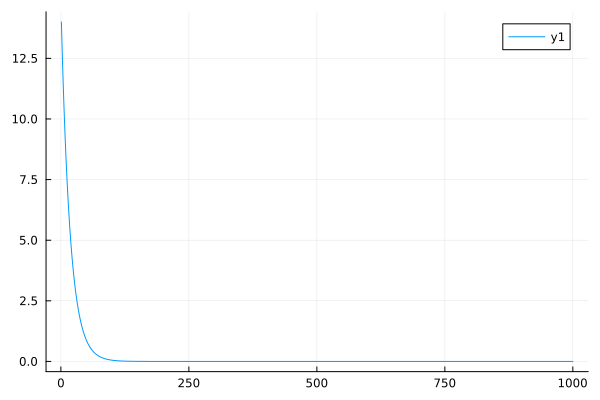

In [18]:
plot(loss)

In [19]:
quote

function linear_regression_error(coef)
    pred = x * coef
    error = 0
    for i in eachindex(y)
        error += (y[i] - pred[i])^2
    end
    return error
end

end |> dump 

Expr
  head: Symbol block
  args: Array{Any}((2,))
    1: LineNumberNode
      line: Int64 3
      file: Symbol In[19]
    2: Expr
      head: Symbol function
      args: Array{Any}((2,))
        1: Expr
          head: Symbol call
          args: Array{Any}((2,))
            1: Symbol linear_regression_error
            2: Symbol coef
        2: Expr
          head: Symbol block
          args: Array{Any}((9,))
            1: LineNumberNode
              line: Int64 3
              file: Symbol In[19]
            2: LineNumberNode
              line: Int64 4
              file: Symbol In[19]
            3: Expr
              head: Symbol =
              args: Array{Any}((2,))
                1: Symbol pred
                2: Expr
            4: LineNumberNode
              line: Int64 5
              file: Symbol In[19]
            5: Expr
              head: Symbol =
              args: Array{Any}((2,))
                1: Symbol error
                2: Int64 0
            6: LineNum